# Solar Energy Prediction
In this notebook we will try to predict the solar energy production using a few different models. These models will also be evaluated at the end.

In [226]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

print('Pandas version:', pd.__version__) # 2.2.3
print('Numpy version:', np.__version__) # 1.26.4
print('TensorFlow version:', tf.__version__) # 2.18.0

Pandas version: 2.2.3
Numpy version: 1.26.4
TensorFlow version: 2.18.0


## Load the dataset
We will start with loading the dataset that has both the weather data and the solar energy production data.

In [227]:
df = pd.read_csv('../data/Model/solar_production_weather.csv')
df

,Date,Time,WindDirection,WindSpeedAvg60min,WindGust,Temperature,Sunshineperhour,GlobalRadiation,HorizontalVisibility,CloudCover,AvgDailyTemperature,capacity,volume,percentage,emission,emissionfactor,Year,Month,Season
0,2021-01-01,01:00:00,230,10,20,-3.2,0,0,0,1,2.970833,0,0,0.0,0,0.0,2021,1,Winter
1,2021-01-01,02:00:00,230,20,30,-2.7,0,0,4,7,2.970833,0,0,0.0,0,0.0,2021,1,Winter
2,2021-01-01,03:00:00,220,20,30,-1.1,0,0,15,8,2.970833,0,0,0.0,0,0.0,2021,1,Winter
3,2021-01-01,04:00:00,230,20,40,1.1,0,0,18,8,2.970833,0,0,0.0,0,0.0,2021,1,Winter
4,2021-01-01,05:00:00,230,30,40,1.9,0,0,44,8,2.970833,0,0,0.0,0,0.0,2021,1,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26273,2023-12-31,18:00:00,200,70,150,8.6,0,0,75,8,8.829167,0,0,0.0,0,0.0,2023,12,Winter
26274,2023-12-31,19:00:00,200,80,140,8.6,0,0,75,8,8.829167,0,0,0.0,0,0.0,2023,12,Winter
26275,2023-12-31,20:00:00,200,70,150,8.2,0,0,70,8,8.829167,0,0,0.0,0,0.0,2023,12,Winter
26276,2023-12-31,21:00:00,200,70,140,8.1,0,0,70,8,8.829167,0,0,0.0,0,0.0,2023,12,Winter


First we need to merge the date and time columns into one column.

In [228]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

df.drop(columns=['Date', 'Time'], inplace=True)

cols = ['Datetime'] + [col for col in df.columns if col != 'Datetime']
df = df[cols]
df.head()

,Datetime,WindDirection,WindSpeedAvg60min,WindGust,Temperature,Sunshineperhour,GlobalRadiation,HorizontalVisibility,CloudCover,AvgDailyTemperature,capacity,volume,percentage,emission,emissionfactor,Year,Month,Season
0,2021-01-01 01:00:00,230,10,20,-3.2,0,0,0,1,2.970833,0,0,0.0,0,0.0,2021,1,Winter
1,2021-01-01 02:00:00,230,20,30,-2.7,0,0,4,7,2.970833,0,0,0.0,0,0.0,2021,1,Winter
2,2021-01-01 03:00:00,220,20,30,-1.1,0,0,15,8,2.970833,0,0,0.0,0,0.0,2021,1,Winter
3,2021-01-01 04:00:00,230,20,40,1.1,0,0,18,8,2.970833,0,0,0.0,0,0.0,2021,1,Winter
4,2021-01-01 05:00:00,230,30,40,1.9,0,0,44,8,2.970833,0,0,0.0,0,0.0,2021,1,Winter


## Modelling
We will try a few different models to see which one performs the best. We will start with the preprocessing.

For evaluation of the models we will first save the standard deviation of the target, so we can compare it to the RMSE.

In [229]:
std = df['volume'].std()
std

3174842.3934088927

In [230]:
def calculate_rmse_vs_std(rmse, std):
    return (rmse / std) * 100

#### Feature Selection
These features are selected based on the correlation matrix that was created in the solar energy production eda notebook. The correlation matrix will be shown again for reference. The target is the volume, since this is the total amount of solar energy that is produced.

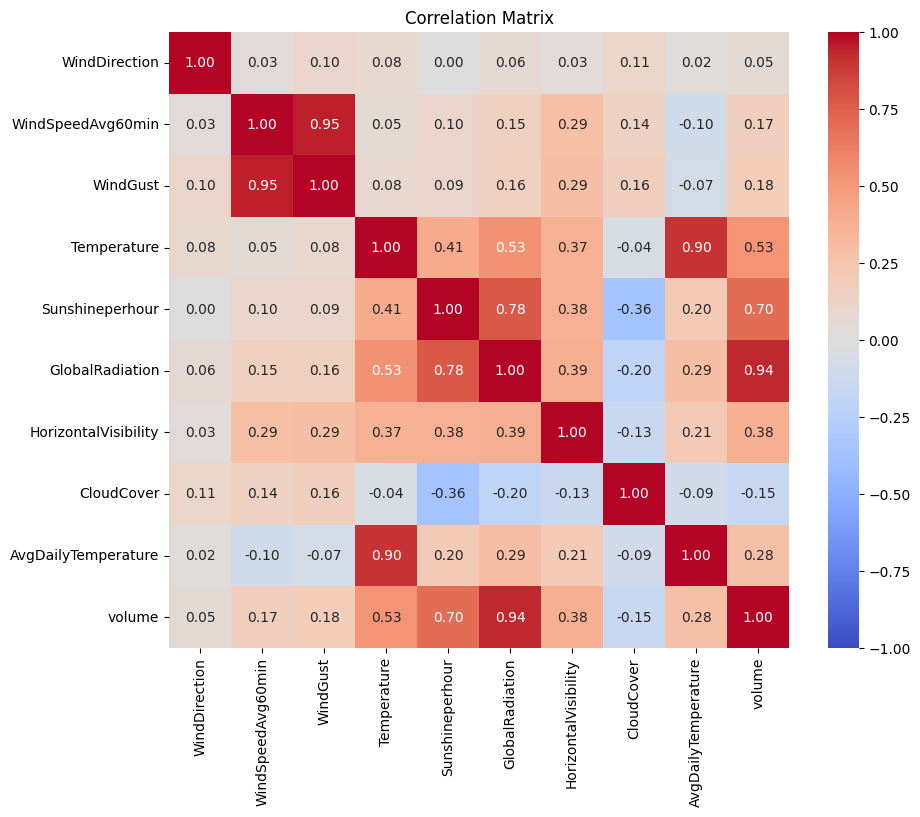

In [231]:
import seaborn as sns

df_corr = df[['WindDirection', 'WindSpeedAvg60min', 'WindGust', 'Temperature',
                                     'Sunshineperhour', 'GlobalRadiation', 'HorizontalVisibility', 
                                     'CloudCover', 'AvgDailyTemperature', 'volume']]

correlation_matrix = df_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', cbar=True)

plt.title('Correlation Matrix')
plt.show()

In [232]:
features = ['Temperature', 'Sunshineperhour', 'GlobalRadiation', 'HorizontalVisibility']
target = 'volume'

### Splitting the data
Next we will split the data into a train and test set, 80% of the data will be used for training and 20% will be used for testing. The data will not be shuffled, since we are using time series data and the order of the dates is important.

In [233]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 26278 observations, of which 21022 are now in the train set, and 5256 in the test set.


## SARIMA
We will start with a SARIMA (Seasonal Autoregressive Integrated Moving Average) model. This is a versatile mdoel that is widely used for time series forecasting. It is an extension of the non-seasonal ARIMA model. The reason why we are using a SARIMA model is because when doing the EDA we found out there are seasonal trends in the production of solar energy.

There are differnt componenets of SARIMA:
* <b>S</b>: Seasonal Component. This represents seasonality, which refers to repeating patterns in the data.
* <b>AR</b>: Autoregressive Component. This models the relationship between the current data point and its past values. 
* <b>I</b>: Integrated Component. This indicates differencing, which transforms non-stationary data into stationary data. 
* <b>MA</b>: Moving Average Component. This models the dependency between the current data point and past prediction errors.

<a href="https://www.geeksforgeeks.org/sarima-seasonal-autoregressive-integrated-moving-average/">source</a>

#### Check Stationarity
Before applying SARIMA it is important to check if the time series data is stationary, because this is what SARIMA assumes. Stationarity refers to the statistical properties of a time series remaining constant over time, such as constant mean, constant variance, and constant autocovariance (<a href="https://www.geeksforgeeks.org/sarima-seasonal-autoregressive-integrated-moving-average/">source</a>).

In [234]:
from statsmodels.tsa.stattools import adfuller

y_diff = y.diff().dropna()

adf_test = adfuller(y_diff)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
if adf_test[1] > 0.05:
    print("Series is not stationary.")

ADF Statistic: -35.73386222307808
p-value: 0.0


The series is stationary and no differencing is required for the non-seasonal component.

To determine the seasonal period we will plot the autocorrelation.

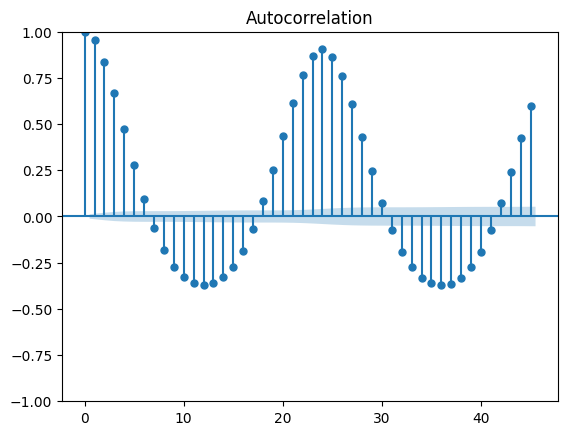

In [235]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df[target])
plt.show()

In this plot we can see the peaks are at lag 24 and 48, this means we have a seasonal period of 24, with the data being hourly and having daily seasonality.

In [236]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA parameters
p, d, q = 1, 0, 1
P, D, Q, s = 1, 0, 1, 24

sarima = SARIMAX(y_train, exog=X_train, order=(p, d, q), seasonal_order=(P, D, Q, s), 
                enforce_stationarity=False, enforce_invertibility=False)
results = sarima.fit(disp=False)

### Evaluation

In [237]:
forecast = results.get_forecast(steps=len(y_test), exog=X_test)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

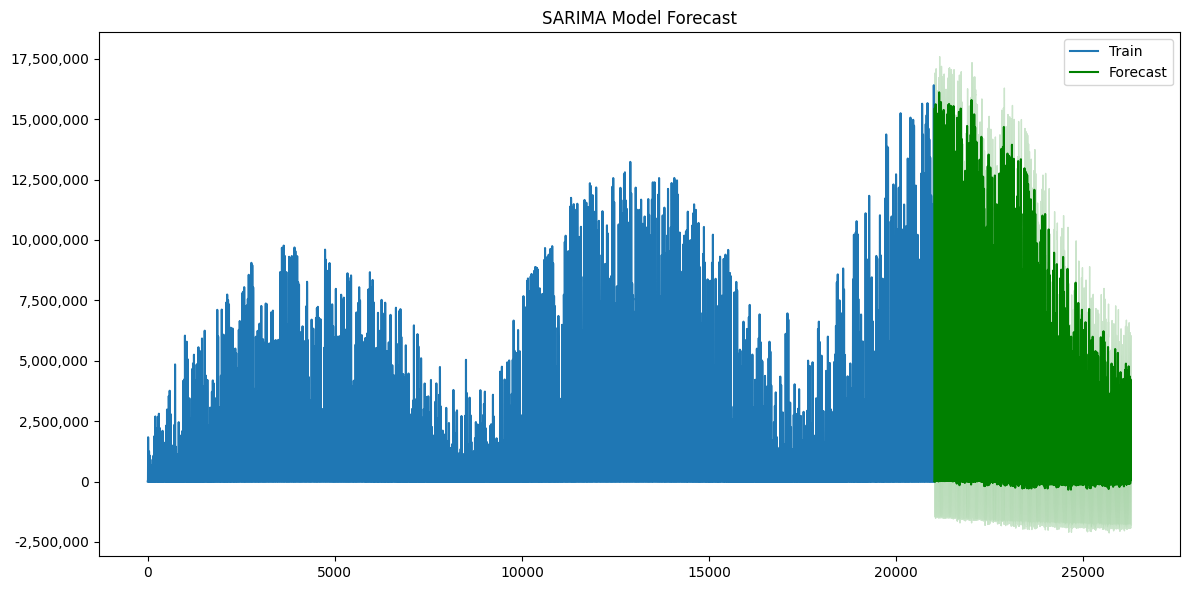

In [238]:
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(12, 6))

plt.plot(y_train, label='Train')
plt.plot(forecast_mean, label='Forecast', color='green')

plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.2)
plt.legend()
plt.title('SARIMA Model Forecast')

formatter = FuncFormatter(lambda x, _: f'{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

In this plot we can see the forecast of the solar energy production.

In [239]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mae = mean_absolute_error(y_test, forecast_mean)
mse = mean_squared_error(y_test, forecast_mean)
rmse = np.sqrt(mean_squared_error(y_test, forecast_mean))

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MAE: 560698.3417553224
MSE: 858768387938.5133
RMSE: 926697.5709143266


In [240]:
sarima_rmse_std = calculate_rmse_vs_std(rmse, std)
print(f'SARIMA RMSE as % of STD: {sarima_rmse_std:.2f}%')

SARIMA RMSE as % of STD: 29.19%


The RMSE is quite large, but if we compare it to the standard deviation it is actually not that bad as it is less than 30% of the std. 
<!-- The RMSE is quite large, this means that the predications deviate significantly from the actual values. The model performs quite poorly. There are a few different explanations on this. The model might not be flexible enough to capture underlying patterns, the seasonal period parameters might not be correct or the selected features might not work for this model. -->

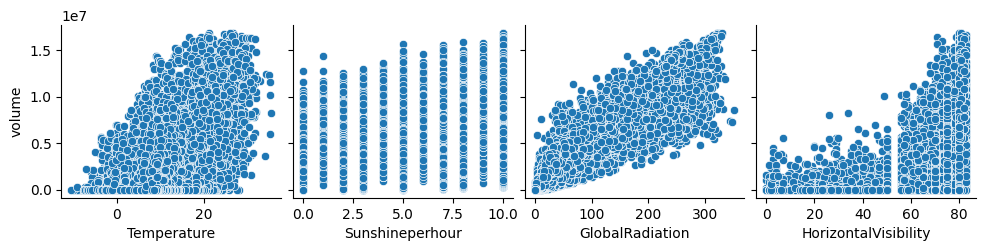

In [241]:
plot = sns.pairplot(df, x_vars=features, y_vars=target)

We will try the same model again, but this time exlude sunshine per hour and cloud cover as features, as there is not a strong correlation based on this pairplot.

## SARIMA (2)
We will try the exact same model as before, but now with only `Temperature`, `GlobalRadiation` and `HorizontalVisibility` as features.

In [242]:
features_2 = ['Temperature', 'GlobalRadiation', 'HorizontalVisibility']

In [243]:
from sklearn.model_selection import train_test_split

X_2 = df[features_2]
y_2 = df[target]

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, shuffle=False)
print("There are in total", len(X_2), "observations, of which", len(X_train_2), "are now in the train set, and", len(X_test_2), "in the test set.")

There are in total 26278 observations, of which 21022 are now in the train set, and 5256 in the test set.


In [244]:
p, d, q = 1, 0, 1
P, D, Q, s = 1, 0, 1, 24

sarima = SARIMAX(y_train_2, exog=X_train_2, order=(p, d, q), seasonal_order=(P, D, Q, s), 
                enforce_stationarity=False, enforce_invertibility=False)
results = sarima.fit(disp=False)

### Evaluation

In [245]:
forecast = results.get_forecast(steps=len(y_test_2), exog=X_test_2)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

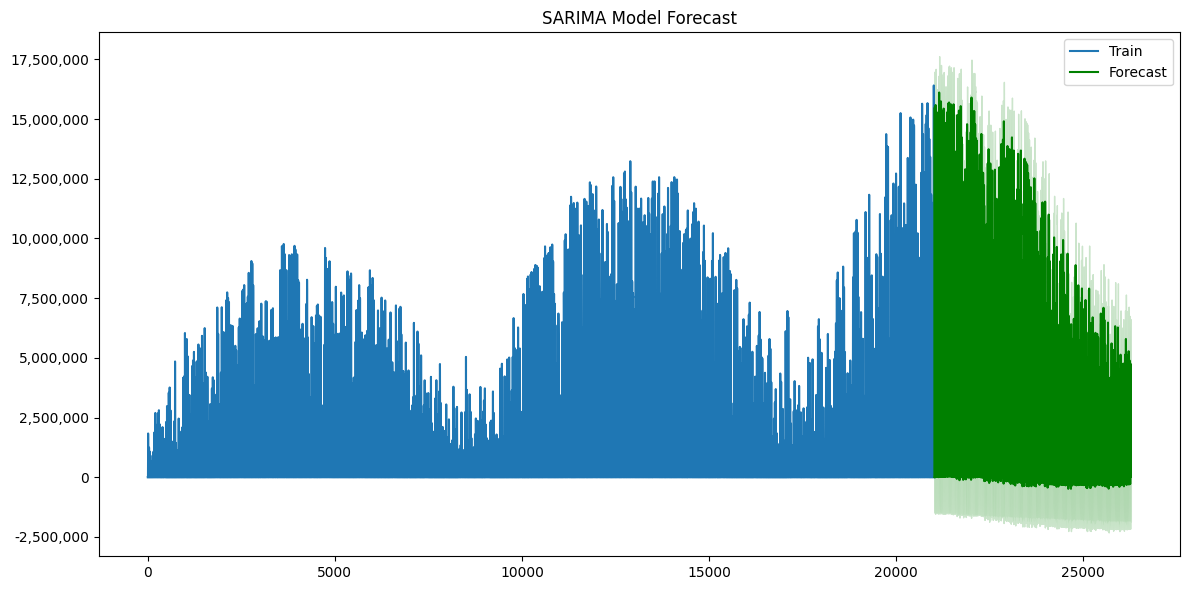

In [246]:
plt.figure(figsize=(12, 6))

plt.plot(y_train_2, label='Train')
plt.plot(forecast_mean, label='Forecast', color='green')

plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.2)
plt.legend()
plt.title('SARIMA Model Forecast')

formatter = FuncFormatter(lambda x, _: f'{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

In [247]:
mae = mean_absolute_error(y_test_2, forecast_mean)
mse = mean_squared_error(y_test_2, forecast_mean)
rmse = np.sqrt(mean_squared_error(y_test_2, forecast_mean))

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MAE: 583183.9951962349
MSE: 941943575866.2404
RMSE: 970537.7766301734


In [248]:
sarima_rmse_std = calculate_rmse_vs_std(rmse, std)
print(f'SARIMA RMSE as % of STD: {sarima_rmse_std:.2f}%')

SARIMA RMSE as % of STD: 30.57%


This model performed slightly worse, which means we will be using the original features.

## SARIMA (3)
This time we will use all of the original features, but change the seasonality parameter to 12, to make it monthly instead of daily. This is to test if the seasonal trend has been selected correctly.

In [249]:
p, d, q = 1, 0, 1
P, D, Q, s = 1, 0, 1, 12

sarima = SARIMAX(y_train, exog=X_train, order=(p, d, q), seasonal_order=(P, D, Q, s), 
                enforce_stationarity=False, enforce_invertibility=False)
results = sarima.fit(disp=False)

### Evaluation

In [250]:
forecast = results.get_forecast(steps=len(y_test), exog=X_test)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

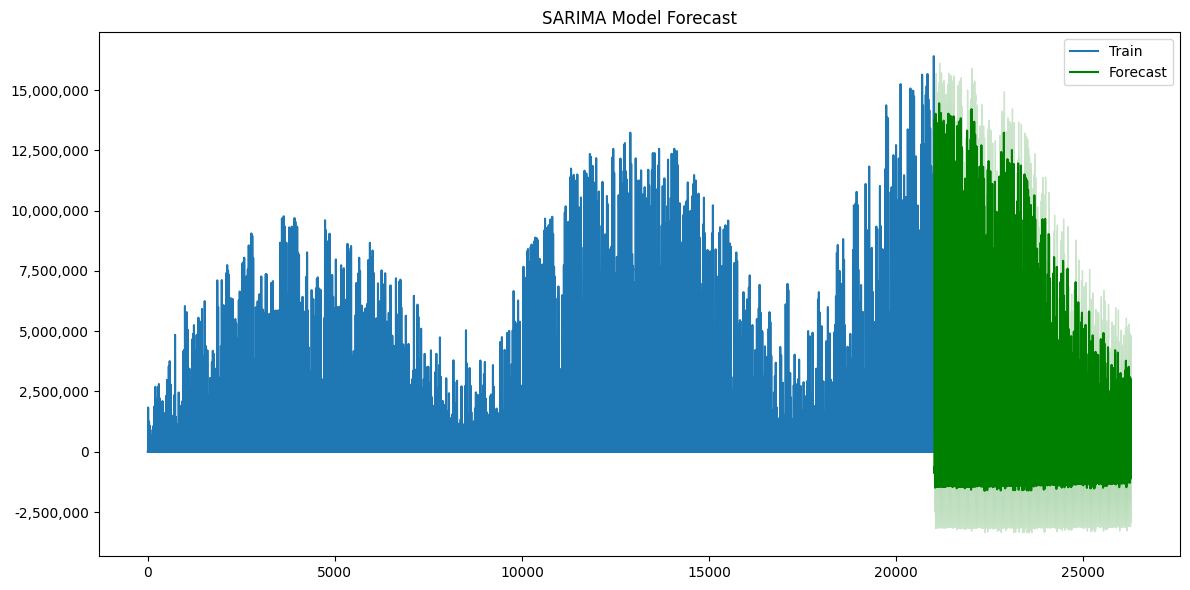

In [251]:
plt.figure(figsize=(12, 6))

plt.plot(y_train, label='Train')
plt.plot(forecast_mean, label='Forecast', color='green')

plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='green', alpha=0.2)
plt.legend()
plt.title('SARIMA Model Forecast')

formatter = FuncFormatter(lambda x, _: f'{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

In [252]:
mae = mean_absolute_error(y_test, forecast_mean)
mse = mean_squared_error(y_test, forecast_mean)
rmse = np.sqrt(mean_squared_error(y_test, forecast_mean))

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MAE: 991985.4154755238
MSE: 1691413112351.9114
RMSE: 1300543.3911838203


In [253]:
sarima_rmse_std = calculate_rmse_vs_std(rmse, std)
print(f'SARIMA RMSE as % of STD: {sarima_rmse_std:.2f}%')

SARIMA RMSE as % of STD: 40.96%


The model performed even more poorly, this means the correct seasonal parameters were chosen the first time.

## LSTM
Next we will try a LSTM (Long Short-Term Memory) model. This is an advanced recurrent neural network, that is ideal for time series. LSTM models are capable of learning long-term dependencies is sequential data. It involves a memory cell, which is controlled by three gates: the input gate, the forget gate and the output gate. The gates decide what information to add to, remove from and output from the memory cell. This allows LSTM networks to selectively retain or discard information, which allows for it to learn long-term dependencies (<a href="https://www.geeksforgeeks.org/deep-learning-introduction-to-long-short-term-memory/">source</a>).

### Feature Selection
We will use the same features we used for our first SARIMA model.

In [254]:
features

['Temperature', 'Sunshineperhour', 'GlobalRadiation', 'HorizontalVisibility']

### Scaling the data
The data should be scaled to values between 0 and 1. This needs to be done first because neural networks are sensitive to the scale of input data and the activation functions that are used work best with scaled inputs. For this we will use a MinMaxScaler, this uses the min and max values of the data for scaling.

In [255]:
from sklearn.preprocessing import MinMaxScaler

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(df[features])
y_scaled = target_scaler.fit_transform(df[[target]])

### Create sequences
We will create sequences of consecutive data points as the input and the output of the target variable corresponding to the time following the sequence. 

In [256]:
sequence_length = 24

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(seq_length, len(X)):
        X_seq.append(X[i-seq_length:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, sequence_length)

### Splitting the data
Again the dataset will be split into a train and test set, with 80% of the data used for training and 20% used for testing. This will be done by slicing the data, so the sequenced time series data is correcly split.

In [257]:
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

### Modelling

In [258]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

model = Sequential()

model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 24, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,251 (122.07 KB)

 Trainable params: 31,251 (122.07 KB)

 Non-trainable params: 0 (0.00 B)

In [259]:
hist = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0132 - val_loss: 0.0106
Epoch 2/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0032 - val_loss: 0.0079
Epoch 3/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0027 - val_loss: 0.0076
Epoch 4/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0024 - val_loss: 0.0057
Epoch 5/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0022 - val_loss: 0.0060
Epoch 6/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0022 - val_loss: 0.0068
Epoch 7/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0021 - val_loss: 0.0074
Epoch 8/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0020 - val_loss: 0.0097
Epoch 9/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0021 - val_loss: 0.0064
Epoch 10/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0020 - val_loss: 0.0059
Epoch 11/100
526/526 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0021 - val_loss: 0.0068
Epoch 12/100
526/526 ━━━━━━━━━━━━━━━━━━━━

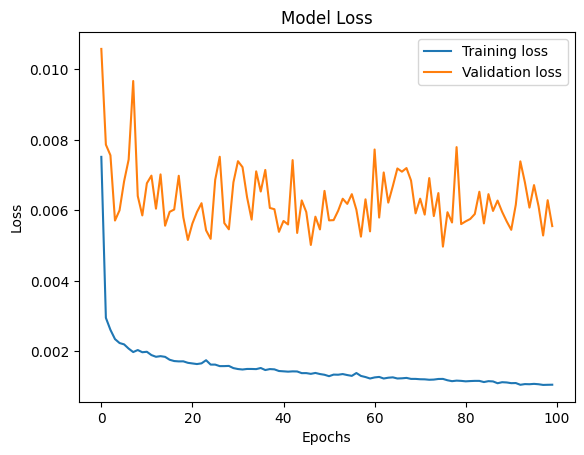

In [260]:
plt.plot(hist.history['loss'], label='Training loss')
plt.plot(hist.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Evaluation

In [261]:
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss}")

Test Loss (MSE): 0.007903608493506908


165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


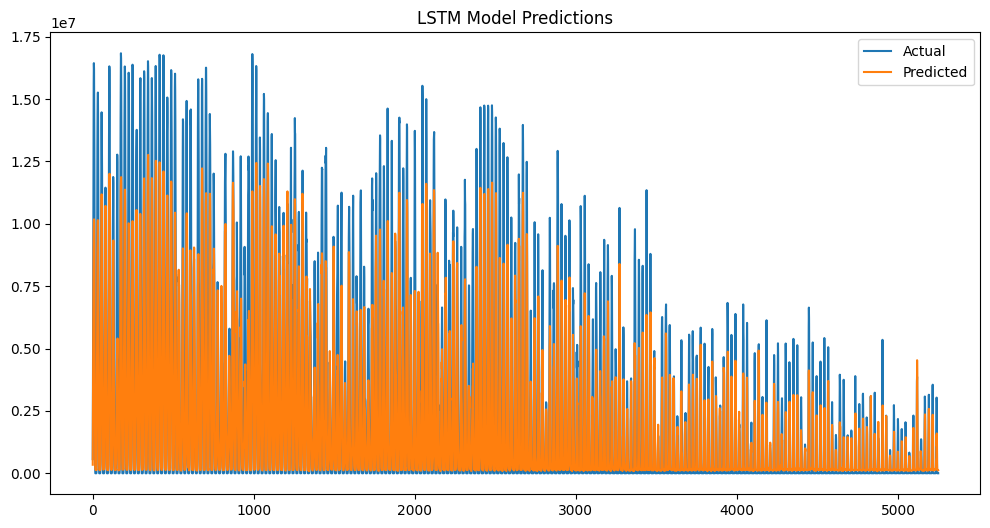

In [262]:
# Make predictions
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_original = target_scaler.inverse_transform(y_test)

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("LSTM Model Predictions")
plt.show()


In [263]:
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 822672.3667753761
RMSE: 1496430.091940025


In [264]:
lstm_rmse_std = calculate_rmse_vs_std(rmse, std)
print(f'SARIMA RMSE as % of STD: {lstm_rmse_std:.2f}%')

SARIMA RMSE as % of STD: 47.13%


By looking at the RMSE we can conclude that the model does not perform well, the RMSE is a lot higher than the SARIMA model. This might be because we do not have enough data, so the model cannot learn the temporal patterns.

# ignore the next part pls it is not finished yet

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

model.add(Dropout(0.2))

model.add(LSTM(50))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 72, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 72, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - loss: 0.0114 - val_loss: 0.0075
Epoch 2/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0032 - val_loss: 0.0090
Epoch 3/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0028 - val_loss: 0.0102
Epoch 4/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0026 - val_loss: 0.0077
Epoch 5/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0025 - val_loss: 0.0153
Epoch 6/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0026 - val_loss: 0.0089
Epoch 7/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0025 - val_loss: 0.0089
Epoch 8/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0024 - val_loss: 0.0071
Epoch 9/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0024 - val_loss: 0.0089
Epoch 10/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0023 - val_loss: 0.0074
Epoch 11/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0021 - val_loss: 0.0076
Epoch 12/100
656/65

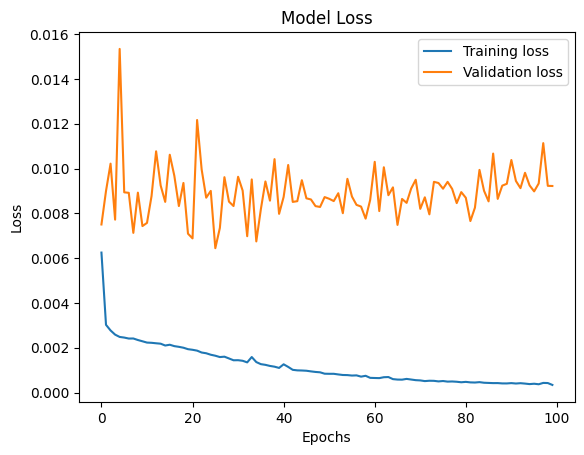

In [32]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [33]:
y_pred = model.predict(X_test)

y_test_actual = scaler.inverse_transform(np.hstack([X_test[:, -1, :], y_test.reshape(-1, 1)]))[:, -1]
y_pred_actual = scaler.inverse_transform(np.hstack([X_test[:, -1, :], y_pred.reshape(-1, 1)]))[:, -1]

from sklearn.metrics import mean_squared_error
import math

rmse = math.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
print(f'Root Mean Squared Error (RMSE): {rmse}')


164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Root Mean Squared Error (RMSE): 1616229.2066344626


In [34]:
df.describe()

,Datetime,WindDirection,WindSpeedAvg60min,WindGust,Temperature,Sunshineperhour,GlobalRadiation,HorizontalVisibility,CloudCover,AvgDailyTemperature,capacity,volume,percentage,emission,emissionfactor,Year,Month
count,26278,26278.000000,26278.000000,26278.000000,26278.000000,26278.000000,26278.000000,26278.000000,26278.000000,26278.000000,2.627800e+04,2.627800e+04,26278.000000,26278.0,26278.0,26278.000000,26278.000000
mean,2022-07-02 10:30:03.013927936,193.201918,33.127331,65.233275,11.278609,2.198227,45.528731,64.943489,6.043268,11.278377,1.997096e+06,1.997096e+06,0.138017,0.0,0.0,2021.999924,6.525611
min,2021-01-01 00:00:00,0.000000,0.000000,0.000000,-10.400000,0.000000,0.000000,0.000000,0.000000,-5.829167,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,2021.000000,1.000000
25%,2021-10-01 17:15:00,110.000000,20.000000,40.000000,6.500000,0.000000,0.000000,61.000000,4.000000,6.841667,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,2021.000000,4.000000
50%,2022-07-02 10:30:00,200.000000,30.000000,60.000000,10.900000,0.000000,2.000000,70.000000,8.000000,10.925000,6.682150e+04,6.682150e+04,0.004756,0.0,0.0,2022.000000,7.000000
75%,2023-04-02 03:45:00,260.000000,40.000000,80.000000,16.100000,3.000000,64.000000,75.000000,8.000000,16.433333,3.003533e+06,3.003533e+06,0.218114,0.0,0.0,2023.000000,10.000000
max,2023-12-31 22:00:00,990.000000,150.000000,310.000000,35.300000,10.000000,351.000000,83.000000,9.000000,26.866667,1.683231e+07,1.683231e+07,0.932454,0.0,0.0,2023.000000,12.000000
std,NaN,124.072629,17.734448,34.503155,6.698246,3.649901,73.348203,17.520688,3.050711,6.036346,3.174842e+06,3.174842e+06,0.211899,0.0,0.0,0.816497,3.447717


Root Mean Squared Error (RMSE): 1654523.719670854 (24h, ['Temperature', 'Sunshineperhour', 'GlobalRadiation'])

Root Mean Squared Error (RMSE): 1559449.636086062 (24h, ['Temperature', 'Sunshineperhour', 'GlobalRadiation', 'CloudCover', 'HorizontalVisibility'])

Root Mean Squared Error (RMSE): 1616229.2066344626 (72h, ['Temperature', 'Sunshineperhour', 'GlobalRadiation', 'CloudCover', 'HorizontalVisibility'])

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

model = Sequential()

model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'))
model.add(Dropout(0.3)) 

model.add(LSTM(64, return_sequences=True, activation='tanh'))
model.add(Dropout(0.3))

model.add(LSTM(32, activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))

model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 72, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 72, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 72, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 72, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,905 (249.63 KB)

 Trainable params: 63,905 (249.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - loss: 0.0131 - mae: 0.0749 - val_loss: 0.0153 - val_mae: 0.0704
Epoch 2/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - loss: 0.0039 - mae: 0.0380 - val_loss: 0.0100 - val_mae: 0.0569
Epoch 3/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 0.0035 - mae: 0.0347 - val_loss: 0.0115 - val_mae: 0.0578
Epoch 4/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 0.0031 - mae: 0.0321 - val_loss: 0.0112 - val_mae: 0.0596
Epoch 5/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 0.0032 - mae: 0.0320 - val_loss: 0.0086 - val_mae: 0.0515
Epoch 6/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 0.0028 - mae: 0.0295 - val_loss: 0.0100 - val_mae: 0.0564
Epoch 7/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 0.0027 - mae: 0.0294 - val_loss: 0.0097 - val_mae: 0.0532
Epoch 8/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 0.0026 - mae: 0.0280 - val_loss: 0.0102 - val_mae: 0.0548
Epoch 9/100
656/656 ━━━━━━━━━━━━

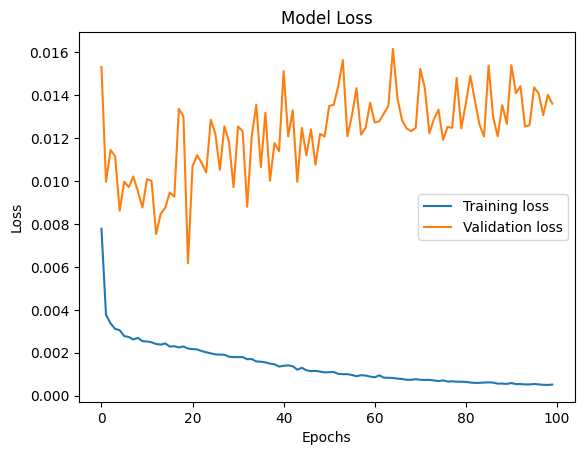

In [38]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [39]:
y_pred = model.predict(X_test)

y_test_actual = scaler.inverse_transform(np.hstack([X_test[:, -1, :], y_test.reshape(-1, 1)]))[:, -1]
y_pred_actual = scaler.inverse_transform(np.hstack([X_test[:, -1, :], y_pred.reshape(-1, 1)]))[:, -1]

from sklearn.metrics import mean_squared_error
import math

rmse = math.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
print(f'Root Mean Squared Error (RMSE): {rmse}')

164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Root Mean Squared Error (RMSE): 1963174.5478914587


In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout

model_bidirectional = Sequential()

model_bidirectional.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model_bidirectional.add(Dropout(0.2))

model_bidirectional.add(Bidirectional(LSTM(64, return_sequences=False)))
model_bidirectional.add(Dropout(0.2))

model_bidirectional.add(Dense(32, activation='relu'))

model_bidirectional.add(Dense(1))

model_bidirectional.compile(optimizer='adam', loss='mean_squared_error')

model_bidirectional.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 72, 256)        │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 72, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,729 (1.17 MB)

 Trainable params: 305,729 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 67s 100ms/step - loss: 0.0084 - val_loss: 0.0120
Epoch 2/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 73s 111ms/step - loss: 0.0030 - val_loss: 0.0110
Epoch 3/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 72s 109ms/step - loss: 0.0026 - val_loss: 0.0082
Epoch 4/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 75s 114ms/step - loss: 0.0026 - val_loss: 0.0050
Epoch 5/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 74s 113ms/step - loss: 0.0025 - val_loss: 0.0092
Epoch 6/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 75s 114ms/step - loss: 0.0024 - val_loss: 0.0122
Epoch 7/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 69s 105ms/step - loss: 0.0025 - val_loss: 0.0087
Epoch 8/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 72s 110ms/step - loss: 0.0024 - val_loss: 0.0124
Epoch 9/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 72s 110ms/step - loss: 0.0023 - val_loss: 0.0068
Epoch 10/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 71s 108ms/step - loss: 0.0022 - val_loss: 0.0103
Epoch 11/100
656/656 ━━━━━━━━━━━━━━━━━━━━ 71s 109ms/step - loss: 0.0021 - val_loss: 0.0088
Epoch 12

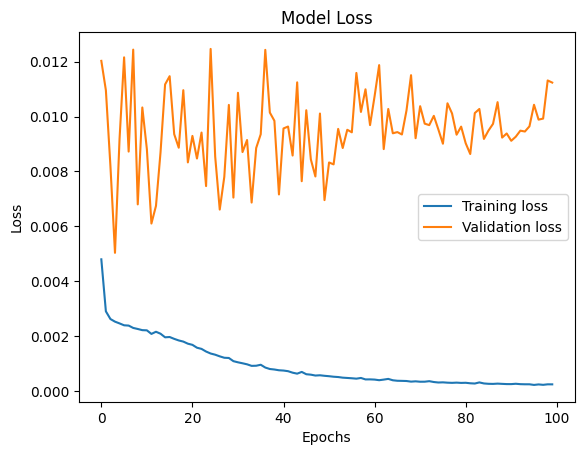

In [41]:
history = model_bidirectional.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [42]:
y_pred = model_bidirectional.predict(X_test)

y_test_actual = scaler.inverse_transform(np.hstack([X_test[:, -1, :], y_test.reshape(-1, 1)]))[:, -1]
y_pred_actual = scaler.inverse_transform(np.hstack([X_test[:, -1, :], y_pred.reshape(-1, 1)]))[:, -1]

from sklearn.metrics import mean_squared_error
import math

rmse = math.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
print(f'Root Mean Squared Error (RMSE): {rmse}')

164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step
Root Mean Squared Error (RMSE): 1784112.495899348


## Seasonal Trends

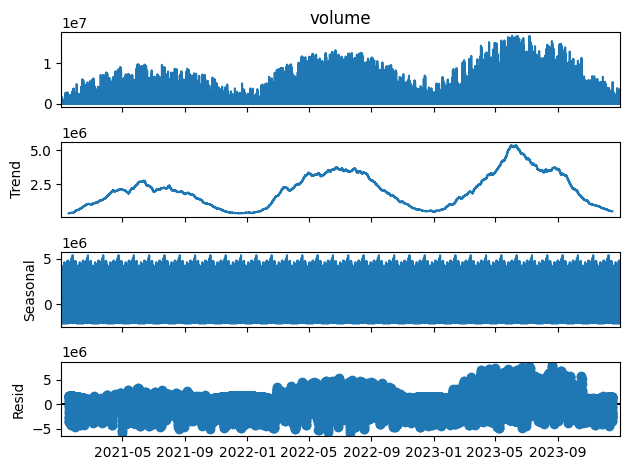

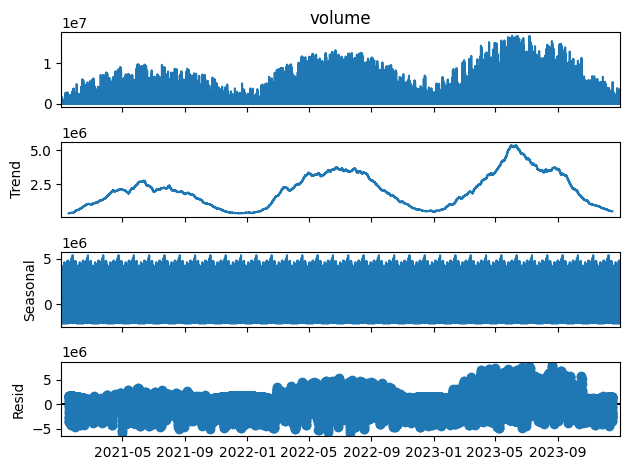

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

time_series = df['volume']

decompose_result = seasonal_decompose(time_series, model='additive', period=24*30)
decompose_result.plot()


In [45]:
p, d, q = 2, 1, 2
P, D, Q, s = 1, 1, 1, 12

sarima_model = SARIMAX(time_series, 
                       order=(p, d, q), 
                       seasonal_order=(P, D, Q, s), 
                       enforce_stationarity=False, 
                       enforce_invertibility=False)
sarima_result = sarima_model.fit()

sarima_result.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has bee

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46089D+01    |proj g|=  4.23957D-01

At iterate    5    f=  1.45268D+01    |proj g|=  1.92850D-01

At iterate   10    f=  1.45069D+01    |proj g|=  1.84426D-01

At iterate   15    f=  1.44999D+01    |proj g|=  2.07250D-01

At iterate   20    f=  1.44822D+01    |proj g|=  4.09486D-01

At iterate   25    f=  1.44726D+01    |proj g|=  1.30261D-01

At iterate   30    f=  1.44722D+01    |proj g|=  2.45159D-02

At iterate   35    f=  1.44716D+01    |proj g|=  5.52101D-02

At iterate   40    f=  1.44715D+01    |proj g|=  2.64590D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               volume   No. Observations:                26278
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood             -380283.000
Date:                              Tue, 17 Dec 2024   AIC                         760580.000
Time:                                      13:48:17   BIC                         760637.228
Sample:                                           0   HQIC                        760598.479
                                            - 26278                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7517      0.010    174.685      0.000       1.732       1.771
ar.L2         -0.8313      0.010    -82.122      0.000      -0.851      -0.811
ma.L1         -1.0451      0.013    -78.386      0.000      -1.071      -1.019
ma.L2          0.0460      0.013      3.452      0.001       0.020       0.072
ar.S.L12      -0.2684      0.020    -13.331      0.000      -0.308      -0.229
ma.S.L12      -0.9235      0.006   -148.801      0.000      -0.936      -0.911
sigma2      4.377e+11   1.33e-14   3.29e+25      0.000    4.38e+11    4.38e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):             41102.16
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               2.91   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.41e+40. Standard errors may be unstable.
"""

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Root Mean Squared Error: 5605068.2487193635


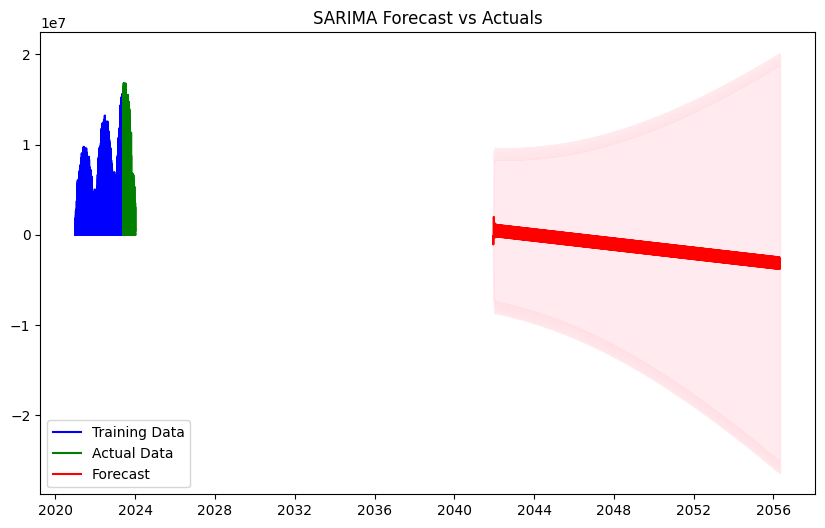

In [46]:
train_size = int(len(time_series) * 0.8)
train, test = time_series[:train_size], time_series[train_size:]

forecast = sarima_result.get_forecast(steps=len(test))
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

rmse = np.sqrt(mean_squared_error(test, forecast_values))
print(f'Root Mean Squared Error: {rmse}')

plt.figure(figsize=(10, 6))
plt.plot(train, label='Training Data', color='blue')
plt.plot(test, label='Actual Data', color='green')
plt.plot(forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_values.index, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast vs Actuals')
plt.legend()
plt.show()


## LSTM

## Sarima

## FNN

## CNN

## Hybrid CNN + LSTM